# Data Preparation
---
In this file, I will tackle the data quality issue of missing values in the banned player dataset. This will involve thresholding and imputation.

In [1]:
from Utils import setup_database_connection, true, false
from Utils import load_all_players
from Utils import COLOUR_BANNED, COLOUR_NON_BANNED, COLOUR_BLUE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

engine = setup_database_connection()
player_data = load_all_players(engine)
banned_player_data = player_data[player_data['has_ban'] == true]
non_banned_player_data = player_data[player_data['has_ban'] == false]

Connecting to database...
Connection successful!
Loaded 302340 players


## Thresholding Missing Values
I will now add a threshold to remove features with too many missing values. I will set the threshold at 50%, meaning any player with more than 50% missing values will be removed from the dataset.

In [2]:
features_to_exclude = []
for feature in banned_player_data.select_dtypes(include=['int64', 'float64']).columns:
    banned_zeros = (banned_player_data[feature] == 0).sum()
    banned_zero_pct = (banned_zeros / len(banned_player_data)) * 100
    
    if banned_zero_pct > 50:
        features_to_exclude.append(feature)

print(f"Features to exclude ({len(features_to_exclude)}):")
for i, col in enumerate(features_to_exclude, 1):
    print(f"\t{i:2}. {col}")

Features to exclude (8):
	 1. he_friends_damage_avg
	 2. rank_faceit_elo
	 3. rank_premier
	 4. rating_clutch
	 5. rating_ct_leetify
	 6. rating_opening
	 7. rating_t_leetify
	 8. t_opening_aggression_success_rate


Now that I have identified the features to exclude, I will drop them from both the banned and non-banned player datasets.

In [3]:
# Create new dataframe with excluded features removed
thresholded_player_data = player_data.drop(columns=features_to_exclude)

print(f"Original dataset: {player_data.shape[1]} features")
print(f"Thresholded dataset: {thresholded_player_data.shape[1]} features")
print(f"Removed {len(features_to_exclude)} features")

Original dataset: 37 features
Thresholded dataset: 29 features
Removed 8 features


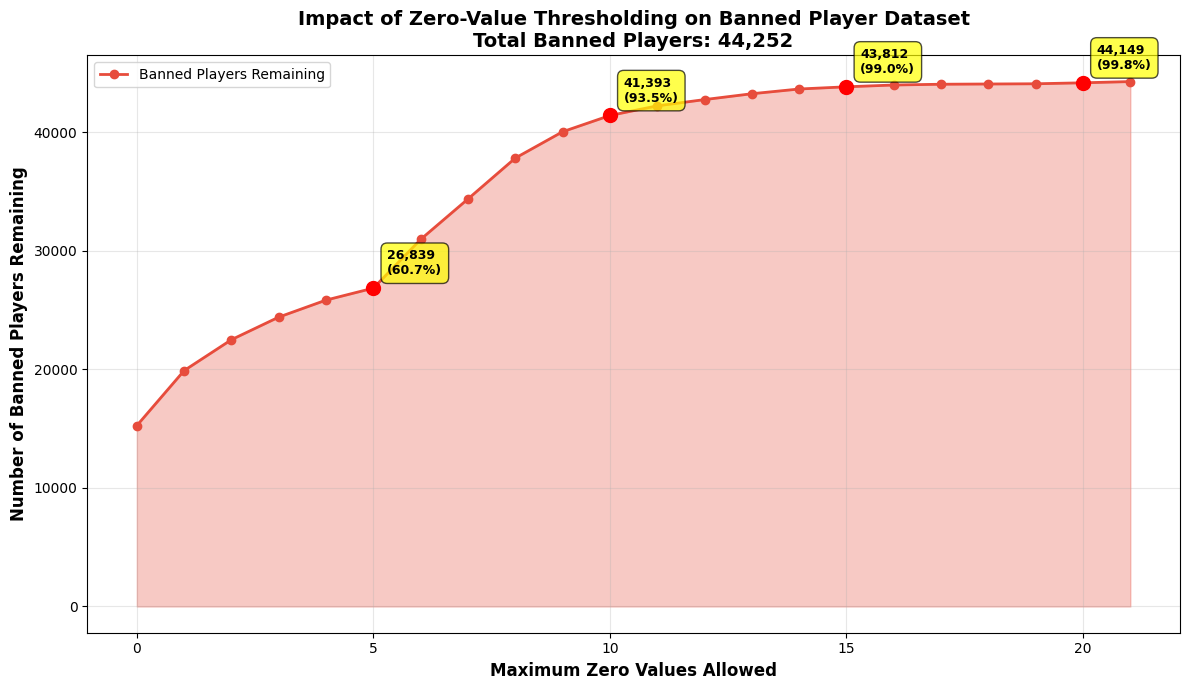

Threshold    Players Remaining    Players Removed      % Remaining    
----------------------------------------------------------------------
0            15,249               29,003               34.46%
5            26,839               17,413               60.65%
10           41,393               2,859                93.54%
15           43,812               440                  99.01%
20           44,149               103                  99.77%

Threshold    Players Remaining    % Remaining    
--------------------------------------------------
0            15,249               34.46%
5            26,839               60.65%
10           41,393               93.54%
15           43,812               99.01%
20           44,149               99.77%


In [4]:
numeric_features = thresholded_player_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

thresholded_banned = thresholded_player_data[thresholded_player_data['has_ban'] == true]
banned_zero_counts = (thresholded_banned[numeric_features] == 0).sum(axis=1)

max_zeros = banned_zero_counts.max()
thresholds = range(0, int(max_zeros) + 1)
players_remaining = []
players_removed = []
pct_remaining = []

total_banned = len(thresholded_banned)

for threshold in thresholds:
    remaining = (banned_zero_counts <= threshold).sum()
    removed = total_banned - remaining
    pct = (remaining / total_banned) * 100
    
    players_remaining.append(remaining)
    players_removed.append(removed)
    pct_remaining.append(pct)

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(thresholds, players_remaining, marker='o', linewidth=2, markersize=6, color=COLOUR_BANNED, label='Banned Players Remaining')
ax.fill_between(thresholds, players_remaining, alpha=0.3, color=COLOUR_BANNED)
ax.set_xlabel('Maximum Zero Values Allowed', fontsize=12, weight='bold')
ax.set_ylabel('Number of Banned Players Remaining', fontsize=12, weight='bold')
ax.set_title(f'Impact of Zero-Value Thresholding on Banned Player Dataset\nTotal Banned Players: {total_banned:,}', fontsize=14, weight='bold')
ax.grid(alpha=0.3)

key_thresholds = [5, 10, 15, 20]
for t in key_thresholds:
    if t < len(players_remaining):
        ax.plot(t, players_remaining[t], 'ro', markersize=10, zorder=5)
        ax.annotate(f'{players_remaining[t]:,}\n({pct_remaining[t]:.1f}%)',
                    xy=(t, players_remaining[t]), xytext=(10, 10),
                    textcoords='offset points', fontsize=9, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"{'Threshold':<12} {'Players Remaining':<20} {'Players Removed':<20} {'% Remaining':<15}")
print("-" * 70)
for i in range(0, int(max_zeros) + 1, 5):
    if i < len(players_remaining):
        print(f"{i:<12} {players_remaining[i]:<20,} {players_removed[i]:<20,} {pct_remaining[i]:.2f}%")

print(f"\n{'Threshold':<12} {'Players Remaining':<20} {'% Remaining':<15}")
print("-" * 50)
for t in [0, 5, 10, 15, 20]:
    if t < len(players_remaining):
        print(f"{t:<12} {players_remaining[t]:<20,} {pct_remaining[t]:.2f}%")

Based on the above graph, I will likely choose a threshold of 2 zero values, removing any players with more than 2 zero value features. I will now analyse and apply this threshold to the entire dataset.

In [5]:
ZERO_THRESHOLD = 2

numeric_features = thresholded_player_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
zero_counts_per_player = (thresholded_player_data[numeric_features] == 0).sum(axis=1)

mask = zero_counts_per_player <= ZERO_THRESHOLD

filtered_player_data = thresholded_player_data[mask].copy()

original_banned_count = (thresholded_player_data['has_ban'] == true).sum()
original_non_banned_count = (thresholded_player_data['has_ban'] == false).sum()
filtered_banned_count = (filtered_player_data['has_ban'] == true).sum()
filtered_non_banned_count = (filtered_player_data['has_ban'] == false).sum()

total_original = len(thresholded_player_data)
total_filtered = len(filtered_player_data)
total_removed = total_original - total_filtered
banned_removed = original_banned_count - filtered_banned_count
non_banned_removed = original_non_banned_count - filtered_non_banned_count

print(f"{'Category':<20} {'Original':<15} {'Filtered':<15} {'Removed':<15} {'% Retained':<15}")
print("-" * 80)
print(f"{'Banned Players':<20} {original_banned_count:<15,} {filtered_banned_count:<15,} {banned_removed:<15,} {(filtered_banned_count/original_banned_count*100):.2f}%")
print(f"{'Non-Banned Players':<20} {original_non_banned_count:<15,} {filtered_non_banned_count:<15,} {non_banned_removed:<15,} {(filtered_non_banned_count/original_non_banned_count*100):.2f}%")
print(f"{'Total Players':<20} {total_original:<15,} {total_filtered:<15,} {total_removed:<15,} {(total_filtered/total_original*100):.2f}%")

# Show class balance
print(f"\nClass Balance:")
print("-" * 50)
print(f"Original - Banned: {(original_banned_count/total_original*100):.2f}% | Non-Banned: {(original_non_banned_count/total_original*100):.2f}%")
print(f"Filtered - Banned: {(filtered_banned_count/total_filtered*100):.2f}% | Non-Banned: {(filtered_non_banned_count/total_filtered*100):.2f}%")

Category             Original        Filtered        Removed         % Retained     
--------------------------------------------------------------------------------
Banned Players       44,252          22,493          21,759          50.83%
Non-Banned Players   258,088         255,577         2,511           99.03%
Total Players        302,340         278,070         24,270          91.97%

Class Balance:
--------------------------------------------------
Original - Banned: 14.64% | Non-Banned: 85.36%
Filtered - Banned: 8.09% | Non-Banned: 91.91%


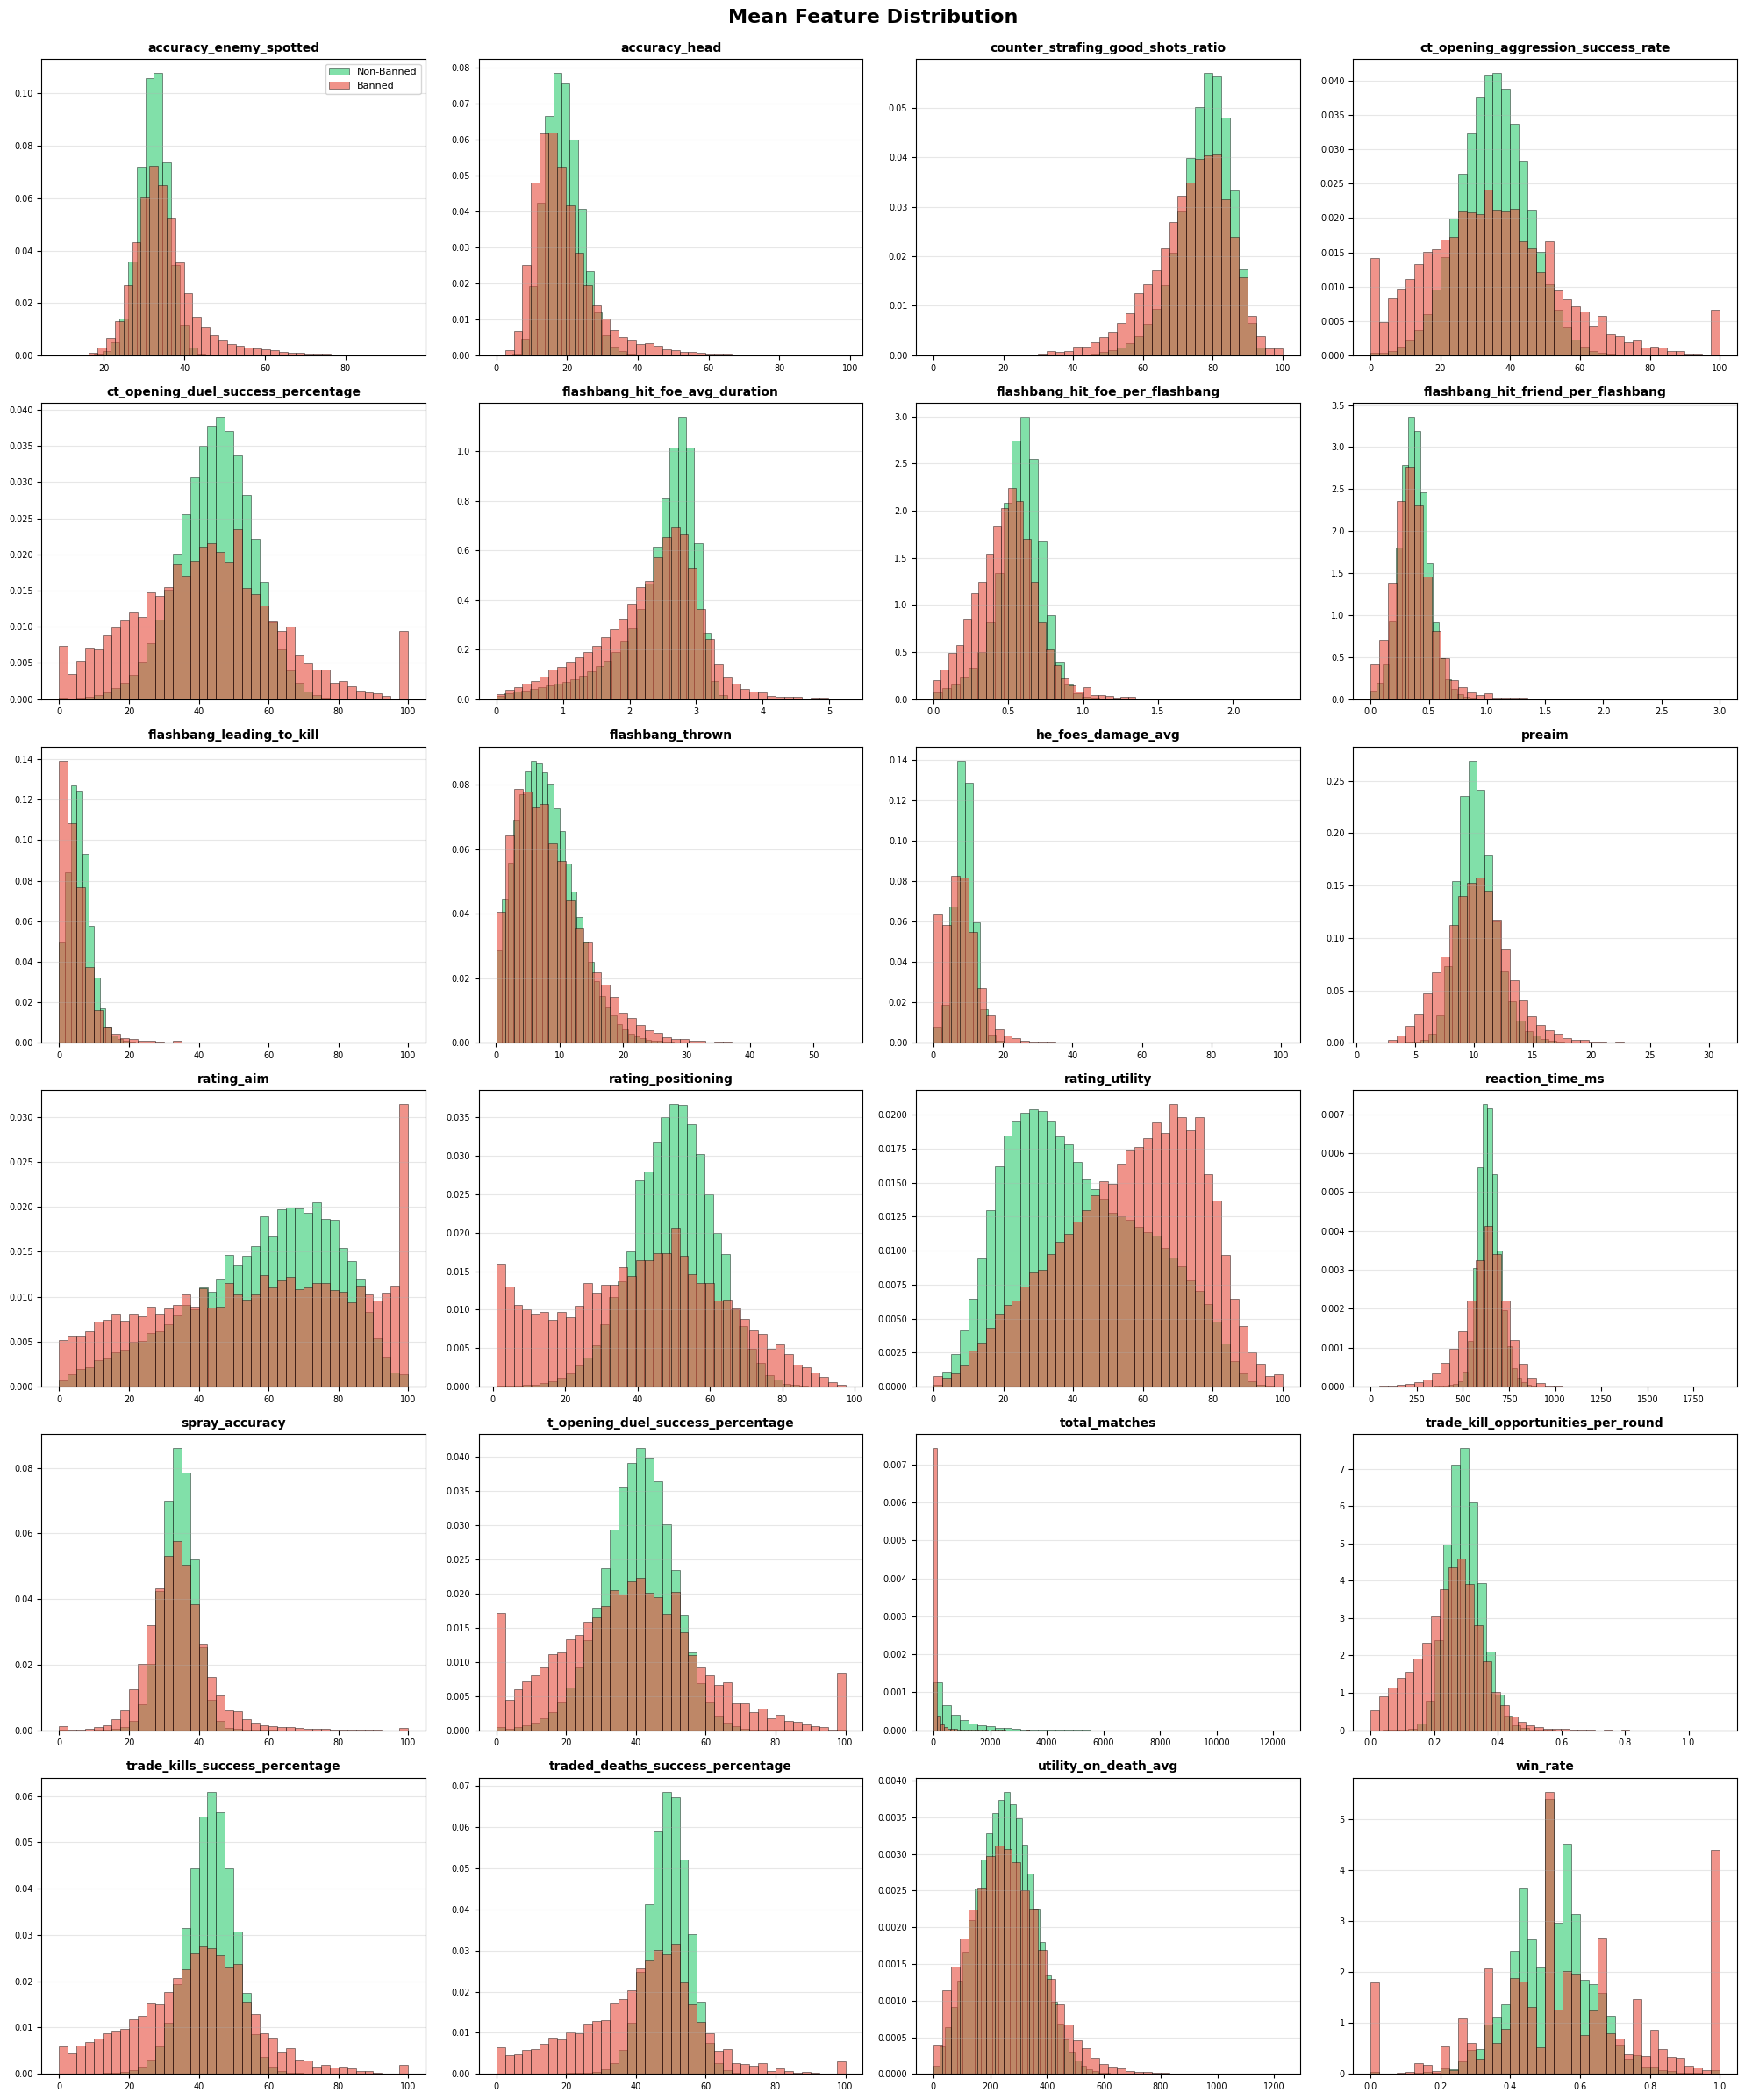

In [6]:
filtered_banned = filtered_player_data[filtered_player_data['has_ban'] == true]
filtered_non_banned = filtered_player_data[filtered_player_data['has_ban'] == false]

features = filtered_player_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_data = filtered_non_banned[feature].dropna()
    banned_data = filtered_banned[feature].dropna()
    
    ax.hist(non_banned_data, bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
            label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(banned_data, bins=40, alpha=0.6, color=COLOUR_BANNED,
            label='Banned', density=True, edgecolor='black', linewidth=0.5)

    ax.set_title(feature, fontsize=10, weight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='both', labelsize=7)
    if idx == 0:
        ax.legend(fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Mean Feature Distribution', fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Conclusion
---
According to the above mean distributions, the processing I have done has definitely rescued the dataset. The means between banned and non banned players are more closely aligned with banned players having generally having slightly higher feature values. While the differences are not huge, they are more consistent across features which should help the model learn better. Certain features seem to show more telling results, I will have to analyse feature by feature and judge which will have the highest predictive power. For example rating_utility seems to be much higher for banned players while features like counter_strafing_good_shots_ratio seem to be more evenly matched.